# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [6]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

[-74.289387   -51.74804755  30.20263346 ...  19.69318218  45.63951982
  86.82373812]


664

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
responses = []
url = 'https://api.openweathermap.org/data/2.5/weather'
for city in cities:
    print(f'Hitting OpenWeather API for {city.title()}')
    params = {
        'q': city,
        'appid': weather_api_key
    }

    responses.append(requests.get(url, params))

Hitting OpenWeather API for Belmonte
Hitting OpenWeather API for Hilo
Hitting OpenWeather API for Honningsvag
Hitting OpenWeather API for Lagoa
Hitting OpenWeather API for Georgetown
Hitting OpenWeather API for Pierre
Hitting OpenWeather API for Albany
Hitting OpenWeather API for Ust-Nera
Hitting OpenWeather API for Saskylakh
Hitting OpenWeather API for Kapaa
Hitting OpenWeather API for Faanui
Hitting OpenWeather API for Tessalit
Hitting OpenWeather API for Marcona
Hitting OpenWeather API for Butaritari
Hitting OpenWeather API for Saint-Francois
Hitting OpenWeather API for Zwedru
Hitting OpenWeather API for Mahebourg
Hitting OpenWeather API for Hobart
Hitting OpenWeather API for Bluff
Hitting OpenWeather API for Clyde River
Hitting OpenWeather API for Amderma
Hitting OpenWeather API for Touros
Hitting OpenWeather API for Jamestown
Hitting OpenWeather API for Port Moresby
Hitting OpenWeather API for Broome
Hitting OpenWeather API for Gat
Hitting OpenWeather API for Darlawn
Hitting OpenW

Hitting OpenWeather API for Lugovskiy
Hitting OpenWeather API for Nouadhibou
Hitting OpenWeather API for Hambantota
Hitting OpenWeather API for Calamar
Hitting OpenWeather API for Caravelas
Hitting OpenWeather API for Laiyang
Hitting OpenWeather API for Cidreira
Hitting OpenWeather API for Goderich
Hitting OpenWeather API for Lebu
Hitting OpenWeather API for Namibe
Hitting OpenWeather API for Bambanglipuro
Hitting OpenWeather API for Saint-Philippe
Hitting OpenWeather API for Igarka
Hitting OpenWeather API for Torbay
Hitting OpenWeather API for Cercal
Hitting OpenWeather API for Sishui
Hitting OpenWeather API for Chalchihuites
Hitting OpenWeather API for Port Hardy
Hitting OpenWeather API for Yeletskiy
Hitting OpenWeather API for Kohima
Hitting OpenWeather API for Tromso
Hitting OpenWeather API for Mar Del Plata
Hitting OpenWeather API for Shubarkuduk
Hitting OpenWeather API for Warqla
Hitting OpenWeather API for Gornopravdinsk
Hitting OpenWeather API for Khasan
Hitting OpenWeather API

Hitting OpenWeather API for Chegdomyn
Hitting OpenWeather API for Chumikan
Hitting OpenWeather API for Ust-Bolsheretsk
Hitting OpenWeather API for Leh
Hitting OpenWeather API for Guaraniacu
Hitting OpenWeather API for Ishigaki
Hitting OpenWeather API for Klaksvik
Hitting OpenWeather API for Vanimo
Hitting OpenWeather API for Lavrentiya
Hitting OpenWeather API for Lautaro
Hitting OpenWeather API for Saint-Augustin
Hitting OpenWeather API for Andenes
Hitting OpenWeather API for Tuatapere
Hitting OpenWeather API for Turayf
Hitting OpenWeather API for Bud
Hitting OpenWeather API for Bay-Khaak
Hitting OpenWeather API for Sandy Bay
Hitting OpenWeather API for Goundam
Hitting OpenWeather API for Iskateley
Hitting OpenWeather API for Grand Gaube
Hitting OpenWeather API for Olavarria
Hitting OpenWeather API for Marrakesh
Hitting OpenWeather API for Naron
Hitting OpenWeather API for Vila Velha
Hitting OpenWeather API for Pacifica
Hitting OpenWeather API for Kamenskoye
Hitting OpenWeather API for

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
cleaned_responses = []
for response in responses:
    if response.status_code == 200:
        cleaned_responses.append(response)
        
len(cleaned_responses), len(responses)

(558, 609)

In [153]:
df_rows = []
for response in responses:
    data = response.json()
    try:
        weather_col = data['weather']
        df = pd.json_normalize(weather_col)
        df1 = pd.json_normalize(data).drop('weather',axis=1)
        df = pd.concat([df, df1], axis=1)
        df = df.loc[:,~df.columns.duplicated()] # removes second id col
        df_rows.append(df)
    except KeyError:
        df = pd.json_normalize(data)
        df = df.loc[:,~df.columns.duplicated()]
        df_rows.append(df)

In [154]:
num_cols = []
for row in df_rows:
    num_cols.append(len(row.columns))
    
max_cols = max(num_cols)

for col in range(len(num_cols)):
    og_col_num = len(df_rows[col].columns)
    if og_col_num != max_cols:
        col_diff = max_cols - og_col_num
        for new_col in range(col_diff):
            df_rows[col][f'filler_{new_col}'] = np.nan

In [174]:
raw_df = pd.concat(df_rows)
raw_df.index = range(len(raw_df))

In [291]:
raw_df['main.temp'] = (raw_df['main.temp'] - 273.15) * 9/5 + 32
raw_df['main.temp_max'] = (raw_df['main.temp_max'] - 273.15) * 9/5 + 32
raw_df['main.temp_min'] = (raw_df['main.temp_min'] - 273.15) * 9/5 + 32

raw_df.to_csv('../output_data/WeatherPy_output/raw_weather.csv')
raw_df.head()

,id,main,description,icon,base,visibility,dt,timezone,name,cod,...,filler_18,filler_19,filler_20,filler_21,filler_22,filler_23,filler_24,filler_25,filler_26,rain.1h
0,802.0,Clouds,scattered clouds,03d,stations,10000.0,1.608738e+09,-10800.0,Belmonte,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,803.0,Clouds,broken clouds,04n,stations,10000.0,1.608738e+09,-36000.0,Hilo,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,803.0,Clouds,broken clouds,04n,stations,10000.0,1.608738e+09,3600.0,Honningsvåg,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,802.0,Clouds,scattered clouds,03d,stations,10000.0,1.608738e+09,-3600.0,Lagoa,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,801.0,Clouds,few clouds,02n,stations,9000.0,1.608738e+09,28800.0,George Town,200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
len(raw_df)

619

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [170]:
# Removing cities with humidity over 100%
# raw_df = raw_df[raw_df['main.humidity'] > 100]
# len(raw_df)

In [171]:
#  Get the indices of cities that have humidity over 100%.


In [172]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

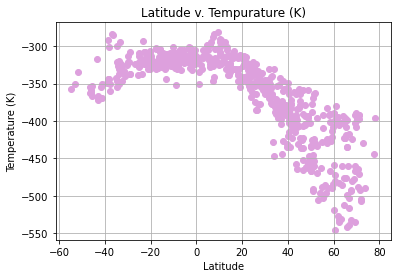

In [307]:
lat = raw_df['coord.lat'].dropna()
temps = raw_df['main.temp'].dropna()

plt.scatter(lat, temps, color='plum')
plt.title('Latitude v. Tempurature (K)')
plt.xlabel('Latitude')
plt.ylabel('Temperature (K)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/temps_lat.png', dpi=400)
plt.show()

## Latitude vs. Humidity Plot

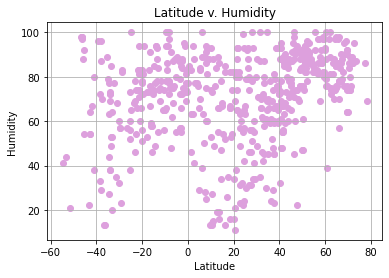

In [293]:
humidity = raw_df['main.humidity'].dropna()

plt.scatter(lat, humidity, color='plum')
plt.title('Latitude v. Humidity')
plt.xlabel('Latitude')
plt.ylabel('Humidity')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/humidity_lat.png', dpi=400)
plt.show()

## Latitude vs. Cloudiness Plot

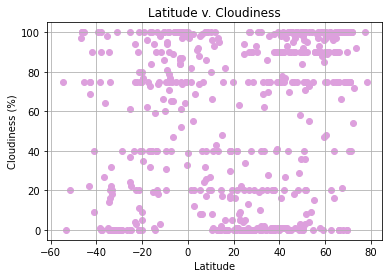

In [294]:
clouds = raw_df['clouds.all'].dropna()

plt.scatter(lat, clouds, color='plum')
plt.title('Latitude v. Cloudiness')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/cloud_lat.png', dpi=400)
plt.show()

## Latitude vs. Wind Speed Plot

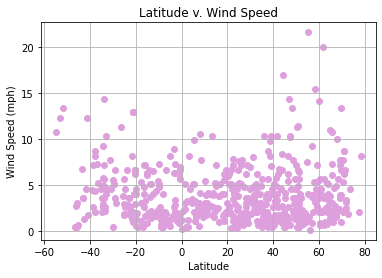

In [295]:
wind_speed = raw_df['wind.speed'].dropna()

plt.scatter(lat, wind_speed, color='plum')
plt.title('Latitude v. Wind Speed')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.grid(True)

plt.savefig(f'../output_data/WeatherPy_output/wind_lat.png', dpi=400)
plt.show()

## Linear Regression

In [296]:
n_hem_df = raw_df[raw_df['coord.lat'] > 0]
s_hem_df = raw_df[raw_df['coord.lat'] < 0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

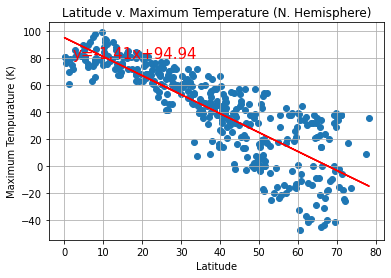

In [298]:
n_lat_max_temp = n_hem_df[['coord.lat','main.temp_max']].dropna()

lat = n_lat_max_temp['coord.lat']
max_temp = n_lat_max_temp['main.temp_max']

slope, intercept, r_value, p_value, std_err = linregress(lat, max_temp)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(n_lat_max_temp['coord.lat'], n_lat_max_temp['main.temp_max'])
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('Latitude v. Maximum Temperature (N. Hemisphere)')
plt.xlabel('Latitude')
plt.ylabel('Maximum Tempurature (K)')
plt.annotate(reg_str, (2, 80), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_max_temp_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

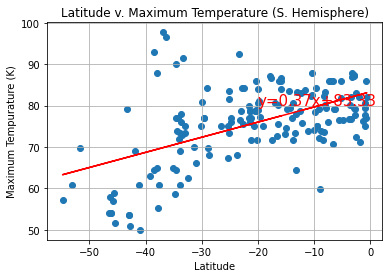

In [299]:
s_lat_max_temp = s_hem_df[['coord.lat','main.temp_max']].dropna()

lat = s_lat_max_temp['coord.lat']
max_temp = s_lat_max_temp['main.temp_max']

slope, intercept, r_value, p_value, std_err = linregress(lat, max_temp)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(s_lat_max_temp['coord.lat'], s_lat_max_temp['main.temp_max'])
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('Latitude v. Maximum Temperature (S. Hemisphere)')
plt.xlabel('Latitude')
plt.ylabel('Maximum Tempurature (K)')
plt.annotate(reg_str, (-20, 80), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_max_temp_lat.png', dpi=400)
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

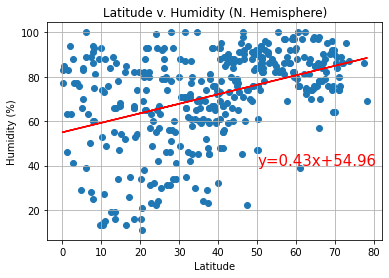

In [300]:
n_lat_humidity = n_hem_df[['coord.lat','main.humidity']].dropna()

lat = n_lat_humidity['coord.lat']
humidity = n_lat_humidity['main.humidity']

slope, intercept, r_value, p_value, std_err = linregress(lat, humidity)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(n_lat_humidity['coord.lat'], n_lat_humidity['main.humidity'])
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('Latitude v. Humidity (N. Hemisphere)')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.annotate(reg_str, (50, 40), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_humidity_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

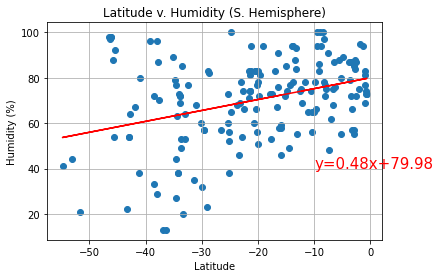

In [301]:
s_lat_humidity = s_hem_df[['coord.lat','main.humidity']].dropna()

lat = s_lat_humidity['coord.lat']
humidity = s_lat_humidity['main.humidity']

slope, intercept, r_value, p_value, std_err = linregress(lat, humidity)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(s_lat_humidity['coord.lat'], s_lat_humidity['main.humidity'])
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('Latitude v. Humidity (S. Hemisphere)')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.annotate(reg_str, (-10, 40), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_humidity_lat.png', dpi=400)
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

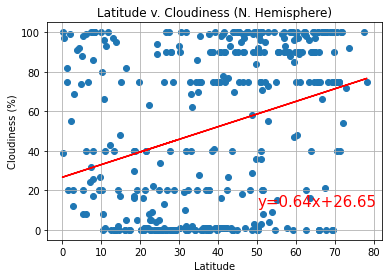

In [302]:
n_lat_cloudiness = n_hem_df[['coord.lat','clouds.all']].dropna()

lat = n_lat_cloudiness['coord.lat']
cloudiness = n_lat_cloudiness['clouds.all']

slope, intercept, r_value, p_value, std_err = linregress(lat, cloudiness)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(n_lat_cloudiness['coord.lat'], n_lat_cloudiness['clouds.all'])
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('Latitude v. Cloudiness (N. Hemisphere)')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.annotate(reg_str, (50, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_cloud_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

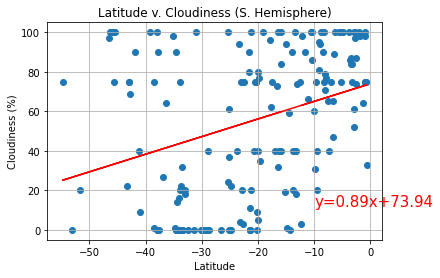

In [303]:
s_lat_cloudiness = s_hem_df[['coord.lat','clouds.all']].dropna()

lat = s_lat_cloudiness['coord.lat']
cloudiness = s_lat_cloudiness['clouds.all']

slope, intercept, r_value, p_value, std_err = linregress(lat, cloudiness)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(s_lat_cloudiness['coord.lat'], s_lat_cloudiness['clouds.all'])
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('Latitude v. Cloudiness (S. Hemisphere)')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.annotate(reg_str, (-10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_cloud_lat.png', dpi=400)
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

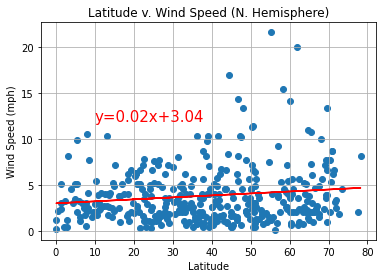

In [304]:
n_lat_wind_speed = n_hem_df[['coord.lat','wind.speed']].dropna()

lat = n_lat_wind_speed['coord.lat']
wind_speed = n_lat_wind_speed['wind.speed']

slope, intercept, r_value, p_value, std_err = linregress(lat, wind_speed)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(n_lat_wind_speed['coord.lat'], n_lat_wind_speed['wind.speed'])
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('Latitude v. Wind Speed (N. Hemisphere)')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(reg_str, (10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/n_hem_wind_lat.png', dpi=400)
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

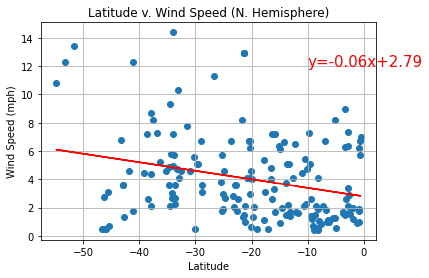

In [306]:
s_lat_wind_speed = s_hem_df[['coord.lat','wind.speed']].dropna()

lat = s_lat_wind_speed['coord.lat']
wind_speed = s_lat_wind_speed['wind.speed']

slope, intercept, r_value, p_value, std_err = linregress(lat, wind_speed)
reg_str = 'y='+ str(round(slope, 2)) +'x+' + str(round(intercept, 2))


plt.scatter(s_lat_wind_speed['coord.lat'], s_lat_wind_speed['wind.speed'])
plt.plot(lat, intercept + slope*lat, 'r', label='fitted line')
plt.title('Latitude v. Wind Speed (N. Hemisphere)')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.annotate(reg_str, (-10, 12), fontsize=15, color='red')
plt.grid(True)

plt.savefig('../output_data/WeatherPy_output/s_hem_wind_lat.png', dpi=400)
plt.show()